In [173]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [174]:
N = 1000 # data points
L = 1 # periods

x = np.arange(N) * L * 2 * np.pi / N
y = np.sin(x)

In [175]:
# Select only datapoints with only non-negative values
data1 = np.column_stack((x,y))
data1 = data1[data1[:,1] >= 0]
x1 = data1[:,0]
y1 = data1[:,1]

# Select only datapoints with only negative values
data2 = np.column_stack((x,y))
data2 = data2[data2[:,1] < 0]
x2 = data2[:,0]
y2 = data2[:,1]

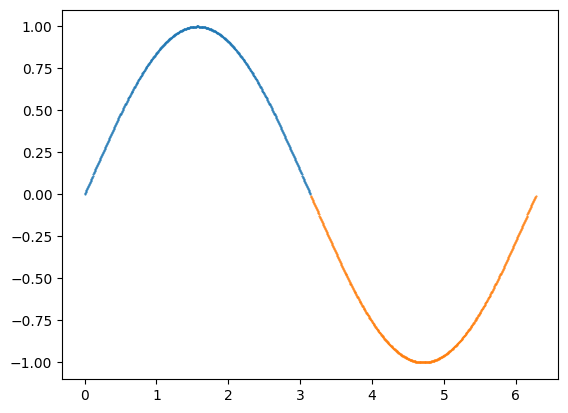

In [176]:
plt.plot(x1,y1,".",markersize=1)
plt.plot(x2,y2,".",markersize=1)
plt.show()

In [198]:
def get_model():
    inputs = tf.keras.layers.Input(shape=(1,))

    v = tf.keras.layers.Dense(512)(inputs)
    v = tf.keras.layers.Activation(tf.keras.activations.sigmoid)(v)

    output = tf.keras.layers.Dense(1)(v)

    model = tf.keras.Model([inputs], output)
    model.compile(loss=tf.keras.losses.mse, optimizer=tf.keras.optimizers.SGD(), metrics=['mean_squared_error'])

    return model

def experiment_1(x1, y1, x2, y2):
    model = get_model()
    model.fit(x1,y1, batch_size=8, epochs=1000)
    model.fit(x2,y2, batch_size=8, epochs=1000)
    return model

def experiment_2(x1, y1, x, y):
    model = get_model()
    model.fit(x1,y1, batch_size=8, epochs=1000)
    model.fit(x,y, batch_size=8, epochs=1000)
    return model

In [199]:
m1 = experiment_1(x1, y1, x2, y2)
m2 = experiment_2(x1, y1, x, y)

Epoch 1/1000
63/63 [==============================] - 0s 669us/step - loss: 145.4606 - mean_squared_error: 145.4606
Epoch 2/1000
63/63 [==============================] - 0s 561us/step - loss: 0.1650 - mean_squared_error: 0.1650
Epoch 3/1000
63/63 [==============================] - 0s 547us/step - loss: 0.1565 - mean_squared_error: 0.1565
Epoch 4/1000
63/63 [==============================] - 0s 573us/step - loss: 0.1241 - mean_squared_error: 0.1241
Epoch 5/1000
63/63 [==============================] - 0s 563us/step - loss: 0.1395 - mean_squared_error: 0.1395
Epoch 6/1000
63/63 [==============================] - 0s 562us/step - loss: 0.1329 - mean_squared_error: 0.1329
Epoch 7/1000
63/63 [==============================] - 0s 573us/step - loss: 0.1200 - mean_squared_error: 0.1200
Epoch 8/1000
63/63 [==============================] - 0s 561us/step - loss: 0.1200 - mean_squared_error: 0.1200
Epoch 9/1000
63/63 [==============================] - 0s 547us/step - loss: 0.1203 - mean_squared_er

32/32 [==============================] - 0s 449us/step


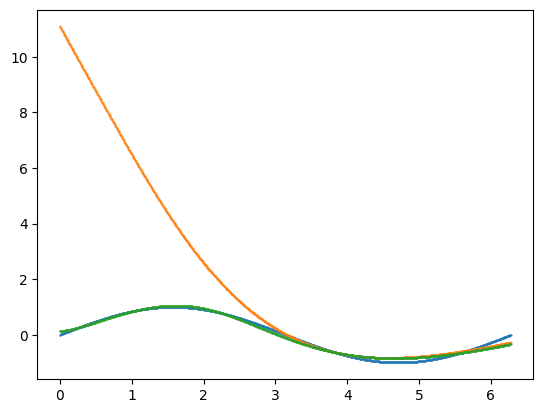

In [202]:
plt.plot(x,y,".",markersize=1)
plt.plot(x,m1.predict(x),".",markersize=1)
plt.plot(x,m2.predict(x),".",markersize=1)
plt.show()

`m1` model fitted for the additional data points `x2` in the second epochs round has errors on the base `x1` set